$\newcommand{\EE}{\mathbb{E}}$

# State-space models

We will demonstrate the usefulness of `GT` on a range of _state-space-models_.

*Disclaimer*: This is just to showcase the power of `GT` and by no means it provides all the functionalities dedicated toolboxes like [Dynamax](https://github.com/probml/dynamax).

## Example: The Kalman Filter

A famous example for timeseries model is the Kalman Filter (and also Smoother). Inference and learning with this model requires exactly the features, that `GT` leverages. Let's see that in a bit more detail. 

The Kalman Filter is a two layered model described by the following equations: 

$$
\color{red}{Z_{t} = A Z_{t-1} + b + \zeta_t} \\
\color{blue}{X_{t} = C Z_t + d + \xi_t},
$$

where $X_t$ are our observations and $Z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\color{red}{\zeta_t \sim N(0,\Sigma_z)}\\
\color{blue}{\xi_t \sim N(0,\Sigma_x)}.
$$

Hence, our model is composed by a $\color{red}{\text{state model}}$ and an $\color{blue}{\text{emission- or observation model}}$.

The joint likelihood is given by

$$
p(Z_{0:T}, X_{1:T}\vert w) = p(Z_0\vert w)\prod_{t=0}^{T-1} \color{blue}{p(X_{t}\vert Z_{t}, w)}\color{red}{p(Z_{t}\vert Z_{t-1}, w)}.
$$

where the parameters $w$ are $A,b,\Sigma_z, C, d, \Sigma_x$ and the mean and covariance of the initial distribution over $Z_0$.

### Inference

We call inference getting the posterior over the latent variables $Z_{0:T}$ given a set of observations $X_{1:T}$. For the Kalman filter this is done in a two-step procedure.

#### Filter procedure:

Assume that you have the estimate for $\color{darkorange}{p(Z_t\vert X_{1:t})}$.

+ Prediction step:

$$
 \color{green}{p(Z_{t+1}\vert X_{1:t})} = \int \color{red}{p(Z_{t+1}Z_t)}\color{darkorange}{p(Z_t\vert X_{1:t})}{\rm d} Z_t
$$

Has the form of an _affine marginal transformation_ $T_{\rm marg}[p(Y|X),p(X)] = p(Y)$.

+ Filter step:

$$
 \color{darkorange}{p(Z_{t+1}\vert X_{1:t+1})} = \frac{\color{blue}{p(X_{t+1}|Z_{t+1})}\color{green}{p(Z_{t+1}\vert X_{1:t})}}{\int \color{blue}{p(X_{t+1}|Z^\prime_{t+1})}\color{green}{p(Z^\prime_{t+1}\vert X_{1:t})}{\rm d} Z^\prime_{t+1}}
$$


Hase the form of a _affine conditional transformation_: $T_{\rm cond}[p(Y|X),p(X)] = p(X\vert Y)$. This procedure can iterate forward through time.

#### Smoothing procedure:

_Smoothing_ is called the backward iteration through time, which yields the density over the trajectories of the latent variables $Z_{0:T}$ given all observations (past __and__ future). This involves also just affine transformations for the Kalman Filter.

Let's generate some example data, to show case how this is done in the `GT`.

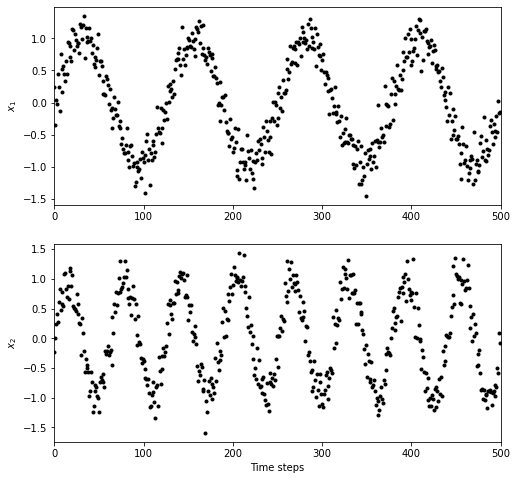

In [1]:
from jax import numpy as jnp
import objax
from matplotlib import pyplot as plt

T = 500
trange = jnp.arange(T)
Dx = 2
Dz = 2
X = jnp.empty((T,Dx))
X = X.at[:,0].set(jnp.sin(trange / 20))
X = X.at[:,1].set(jnp.sin(trange / 10))
noise_x = .2
noise_z = .1
X += noise_x * objax.random.normal(X.shape)

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

### Implementation in `GT`

`GT` provides a `timeseries` module, where a couple of `state_model`s and `observation_model`s and are implemented. They all can be combined to construct different state-space models, and all their parameters can be learnt via an EM procedure (exact or in some cases approximate).

Let's see how this is working for the Kalman filter.

We previously saw that the state and observation model are both linear for the Kalman filter. Hence, we will create a `LinearStateModel` and `LinearObservationModel`, and combine them to a `StateSpaceModel`.

In [2]:
from gaussian_toolbox.timeseries import state_model, observation_model
from gaussian_toolbox.timeseries.ssm import StateSpaceModel

Dz = 2
Dx = X.shape[1]

om = observation_model.LinearObservationModel(Dx=Dx, Dz=Dz)
sm = state_model.LinearStateModel(Dz=Dz, noise_z=.5)

ssm = StateSpaceModel(X, om, sm)

Now let's perform filtering (`forward_sweep`) and smoothing (`backward_sweep`) on the training data.

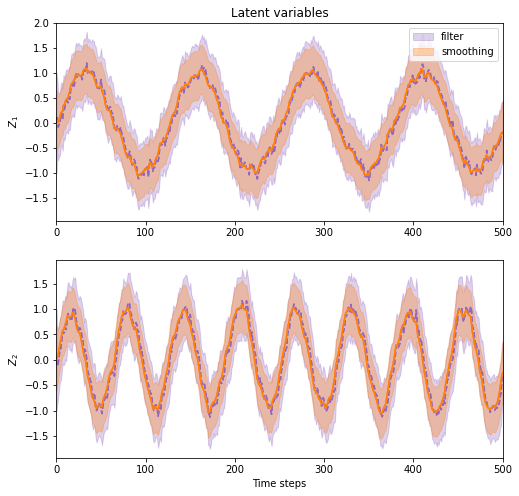

In [3]:
ssm.forward_sweep()

filter_mean = ssm.filter_density.mu
filter_std = jnp.sqrt(ssm.filter_density.Sigma.diagonal(axis1=1, axis2=2))

ssm.backward_sweep()

smoothing_mean = ssm.smoothing_density.mu
smoothing_std = jnp.sqrt(ssm.smoothing_density.Sigma.diagonal(axis1=1, axis2=2))


plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.fill_between(range(0,T+1), filter_mean[:,0] - filter_std[:,0], filter_mean[:,0] + filter_std[:,0], alpha=.3, label='filter', color='C4')
plt.fill_between(range(0,T+1), smoothing_mean[:,0] - smoothing_std[:,0], smoothing_mean[:,0] + smoothing_std[:,0], alpha=.3, label='smoothing', color='C1')
plt.plot(range(0,T+1), filter_mean[:,0], filter_mean[:,0], color='C4', ls='--')
plt.plot(range(0,T+1), smoothing_mean[:,0], smoothing_mean[:,0], color='C1')
plt.xlim([0,500])
plt.ylabel('$Z_1$')
plt.legend()
plt.title('Latent variables')
plt.subplot(212, sharex=ax1)
plt.fill_between(range(0,T+1), filter_mean[:,1] - filter_std[:,1], filter_mean[:,1] + filter_std[:,1], alpha=.3, color='C4')
plt.fill_between(range(0,T+1), smoothing_mean[:,1] - smoothing_std[:,1], smoothing_mean[:,1] + smoothing_std[:,1], alpha=.3, color='C1')
plt.plot(range(0,T+1), filter_mean[:,1], filter_mean[:,1], color='C4', ls='--')
plt.plot(range(0,T+1), smoothing_mean[:,1], smoothing_mean[:,1], color='C1')
plt.xlabel('Time steps')
plt.ylabel('$Z_2$')
plt.show()

We see that the smoothing density has narrower confidence intervals, compared to the filter density, because it contains also future information. Now let's check the estimate of the data density.

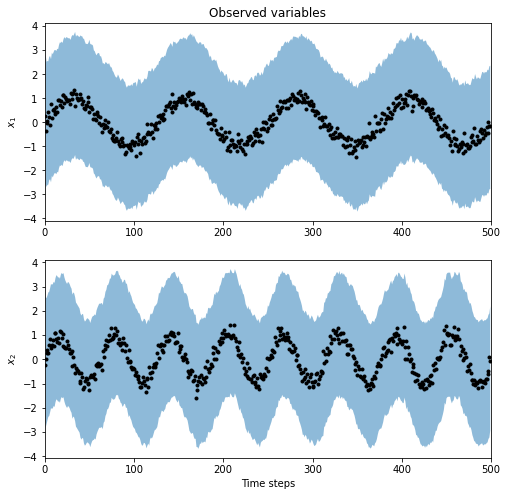

In [4]:
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.title('Observed variables')
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

We see that the confidence intervals are too wide. This is because we did not learn the model parameters $w$ yet. 

### Learning parameters with Expectation Maximization

We do not maximize the likelihood $p(x_{1:T}\vert w)$, but the Q-function which is defined as 

$$
 Q(w,w^{\rm old}) = \EE_{p(z_{0:t}\vert x_{1:T}, w^{\rm old})}\left[\ln p(z_{0:T}, x_{1:T}\vert w)\right] \leq \ln p(x_{1:T}\vert w).
$$

This nicely decomposes into

$$
    Q(w,w^{\rm old}) = \sum_{t=1}^T\EE_{p(z_t\vert x_{1:T}, w^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t}, w)}\right] + \sum_{t=1}^T\EE_{p(z_{t-1:t}\vert x_{1:T}, w^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1},w)}\right] + \EE_{p(z_0\vert x_{1:T}, w^{\rm old})}\left[\ln p(z_0\vert w)\right].
$$

__Important remark__: $\color{blue}{\text{Observation model}}$ and $\color{red}{\text{state model}}$ are always decoupled!

```p_X.integrate('...')``` function is very useful to compute the Q-function easily. 

Now we will use the Expectation maximization (EM) algorithm, where we infer the density over trajectories as we have seen before (aka E-Step). And then given that density we maximize the $Q$ function with respect to parameters $w$.

Let's see how this is done in `GT`. We just need to invoke `ssm.fit()`, and the model will use the EM procedure.

Iteration 10 - Log likelihood=-51.3
Iteration 20 - Log likelihood=-47.9
EM did converge.


Text(0, 0.5, 'Log likelihood')

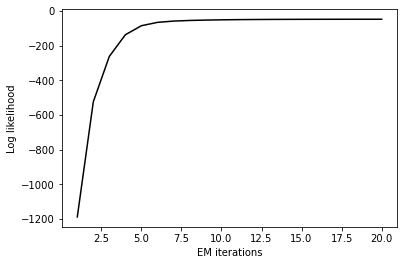

In [5]:
ssm.fit()
plt.plot(jnp.arange(1, len(ssm.llk_list) + 1), ssm.llk_list, 'k')
plt.xlabel('EM iterations')
plt.ylabel('Log likelihood')

Let's check the data fit again. We see that this looks much better now.

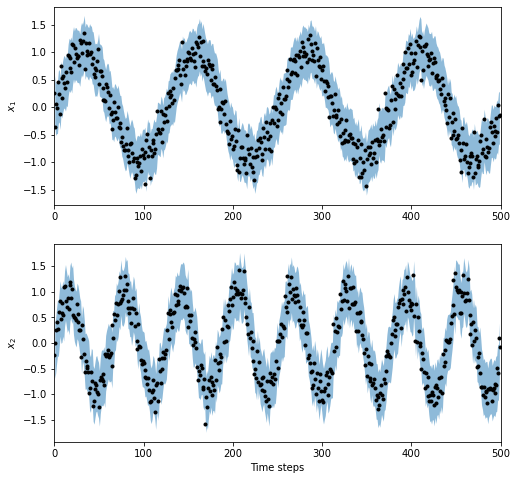

In [6]:
p_x = ssm.compute_data_density() # int p(x|z)p(z)dz
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

## Model overview

While we saw just the simplest state-space model with everything linear, `GT` provides a range of state- and obsevration models, which include also non-linearities, or are designed for heteroscedastic data. 

__Available state models__

| Model name | State equation | Short description | Approximation |
|---|---|---|---|
| `LinearStateModel` | $$X_t = AZ_t + b + \zeta_t$$ | Linear mean |Exact|
| `LRBFMStateModel` | $$X_t = A\phi(Z_t) + b + \zeta_t$$ | Mean with linear and radial basis function features| Moment matching|
| `LSEMStateModel` | $$X_t = A\phi(Z_t) + b + \zeta_t$$ | Mean with linear and squared exponential features|Moment matching|
| `NNControlStateModel` |$$X_t = A(u_t)Z_t + d(u_t) + \zeta(Z_t)$$| Mean depending on control variables through a network|Exact|

__Available observation models__

| Model name | Observation equation | Short description | Approximation |
|---|---|---|---|
| `LinearObservationModel` | $X_t = CZ_t + d + \xi_t$ | Linear mean |Exact|
| `LRBFMObservationModel` | $$X_t = C\phi(Z_t) + d + \xi_t$$ | Mean with linear and radial basis function features|Moment matching|
| `LSEMObservationModel` | $$X_t = C\phi(Z_t) + d + \xi_t$$ | Mean with linear and squared exponential features|Moment matching|
| `HCCovObservationModel` |$$X_t = CZ_t + d + \xi(Z_t)$$| Linear mean, but _heteroscedastic_ noise|Moment matching & lower bound for $Q$|

And the nice thing is, that any state model can be combined with any observation model. (As a recommendation for starting take one of the two still Linear before getting too complex.) Overall fitting time will increase with the complexity of the models you choose (Linear model is fastest).
